# Bollinger Bands and Fibonacci Retracement Strategy
The Bollinger Bands and Fibonacci Retracement strategy is a trading strategy that combines Bollinger Bands and Fibonacci retracement levels. This strategy uses Bollinger Bands to measure market volatility and generate trading signals based on price breaking above or below the Bollinger Bands. At the same time, the strategy uses Fibonacci retracement levels to identify potential support and resistance levels, and therefore entry and exit points for trades.


Bollinger Bands consists of three lines: the middle track, the upper track and the lower track. The middle rail is the moving average of price, and the upper rail and the lower rail are based on the middle rail plus and minus a certain standard deviation respectively. When the price breaks through the upper band, it indicates that the market may enter the overbought area, generating a sell signal; when the price breaks through the lower band, it indicates that the market may enter the oversold area, generating a buy signal.

Fibonacci retracement levels are price levels calculated based on the Fibonacci series. These levels are often considered key support and resistance levels for the market. When prices pull back to these levels, the market may reverse or continue its original trend.

The decision-making process for this strategy is as follows:

- When the price breaks through the lower Bollinger Band downwards, a buy signal is generated and a long position is opened.
- When the price breaks above the upper Bollinger Band upwards, a sell signal is generated and a short position is opened.
- Use Fibonacci retracement levels to determine trade entry, exit, stop loss, and target levels.
- 
## The Strategy Score System
The strategy score ranges from -100 to +100 and is categorized into five signal zones:

+60 to +100: Strong Buy
+20 to +60: Moderate Buy
-20 to +20: Hold
-60 to -20: Moderate Sell
-100 to -60: Strong Sell

### How the Score is Calculated
The score is a weighted combination of four key components:

### Bollinger Band Position (30% weight) - Based on the %B indicator:

When price is near the lower band (%B close to 0): Positive contribution
When price is near the upper band (%B close to 1): Negative contribution


### Volatility Assessment (15% weight):

Considers both current Bollinger Band width and recent changes in width
Narrow bands with expanding width can signal potential breakouts
High volatility reduces signal reliability


### Fibonacci Level Interaction (35% weight):

Highest weight because it's the core of this combined strategy
Measures proximity to key Fibonacci levels
Considers whether price is bouncing off or breaking through a level
Accounts for whether the level is acting as support or resistance


### Price Momentum (20% weight):

RSI-like momentum indicator to identify overbought/oversold conditions
Oversold conditions (like RSI below 30) contribute positively
Overbought conditions (like RSI above 70) contribute negatively



### How to Use the Strategy Score

### Entry and Exit Signals:

Enter long positions when the score moves above +60 (Strong Buy)
Exit long positions when the score falls below +20 (Hold or lower)
Enter short positions when the score falls below -60 (Strong Sell)
Exit short positions when the score rises above -20 (Hold or higher)


### Position Sizing:

The magnitude of the score indicates conviction
Use higher position sizes when scores are extreme (+90 or -90)
Use smaller position sizes when scores are closer to thresholds (+65 or -65)


### Confirmation and Risk Management:

Wait for at least 2-3 consecutive days in the same signal zone before acting
Place stop losses based on the nearest Fibonacci level in the opposite direction
For long positions, consider taking partial profits when approaching key resistance levels
For short positions, consider covering partially when approaching key support levels


### Score Component Analysis:

Examine which components are driving the overall score
Stronger signals occur when all components align in the same direction
Be cautious when components contradict each other


### Visual Analysis:

The strategy score chart clearly shows buy/sell zones with color-coding
Monitor how the score interacts with zone boundaries
Look for divergences between price action and the score

In [31]:
from typing import List, Dict, Any, Optional
from langgraph.graph import StateGraph, END

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.tools import BaseTool
from langchain_openai import ChatOpenAI
import pandas as pd
import numpy as np
import yfinance as yf  
import os
from langgraph.prebuilt import ToolNode 
from langchain.agents.agent_types import AgentType
import os
from google.oauth2 import service_account
from dotenv import dotenv_values
import json
# import vertexai
# from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings, GoogleGenerativeAI
# from langchain_openai import ChatOpenAI
from datetime import datetime , timedelta
from langchain_core.tools import tool

In [32]:
from langgraph.graph import StateGraph, START, END

In [33]:
config = dotenv_values("./keys/.env")

OPENAI_API_KEY = config.get("OPENAI_API_KEY")
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY

In [34]:
# Ensure you have your OpenAI API key set as an environment variable
if "OPENAI_API_KEY" not in os.environ:
    raise ValueError("Please set the OPENAI_API_KEY environment variable.")

In [35]:
ticker = "NVDA"
end_date = datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.now() - timedelta(days=365)).strftime('%Y-%m-%d')

In [36]:
# Set parameters
ticker = "NVDA"
period = '1y'  # 1 year of data
window = 20    # 20 Days window

# Download data
print(f"Downloading data for {ticker}...")

data = yf.download(ticker, period=period,multi_level_index=False) 

[*********************100%***********************]  1 of 1 completed


In [37]:
def fetch_data(ticker:str, period:str):
        """Fetch historical stock data from Yahoo Finance."""
        data = yf.download(ticker, period=period ,multi_level_index=False)
        return data
    
def calculate_bollinger_bands(data:pd.DataFrame, ticker:str, period:str="1y",window:int=20, num_std:int=2):
    """Calculate Bollinger Bands."""
    if data is None:
        fetch_data(ticker=ticker, period=period)
        
    # Calculate moving average and standard deviation
    data['MA'] = data['Close'].rolling(window=window).mean()
    data['STD'] = data['Close'].rolling(window=window).std()
    
    # Calculate upper and lower Bollinger Bands
    data['Upper_Band'] = data['MA'] + (data['STD'] * num_std)
    data['Lower_Band'] = data['MA'] - (data['STD'] * num_std)
    
    # Calculate Bollinger Band width
    data['BB_Width'] = (data['Upper_Band'] - data['Lower_Band']) / data['MA']
    
    # Calculate Bollinger Band %B
    data['%B'] = (data['Close'] - data['Lower_Band']) / (data['Upper_Band'] - data['Lower_Band'])
    
    return data

In [38]:
calculate_bollinger_bands(data=data, window=20,ticker=ticker)

,Close,High,Low,Open,Volume,MA,STD,Upper_Band,Lower_Band,BB_Width,%B
Date,,,,,,,,,,,
2024-05-03,88.759834,89.251669,87.011408,87.760163,398341000,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-06,92.109726,92.189701,89.025740,89.360629,376203000,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-07,90.524254,91.750848,88.981761,91.068074,437342000,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-08,90.382301,91.164042,89.390623,89.453606,325721000,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-09,88.717850,91.042083,88.202020,90.499262,378013000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2025-04-28,108.730003,110.370003,106.019997,109.690002,207708500,105.2700,6.096531,117.463063,93.076938,0.231653,0.641884
2025-04-29,109.019997,110.199997,107.440002,107.669998,170444300,105.3020,6.115365,117.532730,93.071270,0.232298,0.651994
2025-04-30,108.919998,108.919998,104.080002,104.470001,235044600,105.2405,6.070061,117.380622,93.100377,0.230712,0.651543


In [39]:
def find_swing_points(data:pd.DataFrame, window:int=10, debug:bool=False):
    """
    Find swing high and swing low points for Fibonacci retracement.
    
    Parameters:
    -----------
    window : int
        Window size to identify swing points (default: 10)
    """
    if 'Upper_Band' not in data.columns:
        calculate_bollinger_bands()
        
    
    # Find swing high points
    data['Swing_High'] = False
    data['Swing_Low'] = False
    
    # Find swing high points
    for i in range(window, len(data) - window):
        if all(data['High'].iloc[i] > data['High'].iloc[i-j] for j in range(1, window+1)) and \
           all(data['High'].iloc[i] > data['High'].iloc[i+j] for j in range(1, window+1)):
            data.loc[data.index[i], 'Swing_High'] = True
    
    # Find swing low points
    for i in range(window, len(data) - window):
        if all(data['Low'].iloc[i] < data['Low'].iloc[i-j] for j in range(1, window+1)) and \
           all(data['Low'].iloc[i] < data['Low'].iloc[i+j] for j in range(1, window+1)):
            data.loc[data.index[i], 'Swing_Low'] = True
    
    # Debug information
    if debug:
        high_count = data['Swing_High'].sum()
        low_count = data['Swing_Low'].sum()
        print(f"Found {high_count} swing highs and {low_count} swing lows")
        
        # Check if we have too few swing points
        if high_count < 2 or low_count < 2:
            print("WARNING: Too few swing points detected. Consider using a smaller window or more data.")
    
    return data
    

In [10]:
find_swing_points(data=data)

,Close,High,Low,Open,Volume,MA,STD,Upper_Band,Lower_Band,BB_Width,%B,Swing_High,Swing_Low
Date,,,,,,,,,,,,,
2024-05-03,88.759834,89.251669,87.011408,87.760163,398341000,NaN,NaN,NaN,NaN,NaN,NaN,False,False
2024-05-06,92.109726,92.189701,89.025740,89.360629,376203000,NaN,NaN,NaN,NaN,NaN,NaN,False,False
2024-05-07,90.524254,91.750848,88.981761,91.068074,437342000,NaN,NaN,NaN,NaN,NaN,NaN,False,False
2024-05-08,90.382301,91.164042,89.390623,89.453606,325721000,NaN,NaN,NaN,NaN,NaN,NaN,False,False
2024-05-09,88.717850,91.042083,88.202020,90.499262,378013000,NaN,NaN,NaN,NaN,NaN,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-28,108.730003,110.370003,106.019997,109.690002,207708500,105.2700,6.096531,117.463063,93.076938,0.231653,0.641884,False,False
2025-04-29,109.019997,110.199997,107.440002,107.669998,170444300,105.3020,6.115365,117.532730,93.071270,0.232298,0.651994,False,False
2025-04-30,108.919998,108.919998,104.080002,104.470001,235044600,105.2405,6.070061,117.380622,93.100377,0.230712,0.651543,False,False


In [40]:
def calculate_fibonacci_levels(data:pd.DataFrame,window:int=10, fibonacci_levels:List=[0, 0.236, 0.382, 0.5, 0.618, 0.786, 1], debug:bool=False):
    """Calculate Fibonacci retracement levels based on last swing high and low."""
    if 'Swing_High' not in data.columns:
        find_swing_points(data=data, window=window)
    
    # Find all swing highs and swing lows
    swing_highs = data[data['Swing_High'] == True]
    swing_lows = data[data['Swing_Low'] == True]
    
    if len(swing_highs) < 2 or len(swing_lows) < 2:
        if debug:
            print(f"Not enough swing points: {len(swing_highs)} highs, {len(swing_lows)} lows")
        return None
    
    # FIXED: Get the two most recent swings to determine trend
    recent_swings = pd.concat([
        swing_highs.assign(Type='High').iloc[-2:],
        swing_lows.assign(Type='Low').iloc[-2:]
    ]).sort_index()
    
    if len(recent_swings) < 2:
        if debug:
            print("Not enough recent swings to determine trend")
        return None
    
    # Determine most recent significant swing
    last_swing = recent_swings.iloc[-1]
    prev_swing = recent_swings.iloc[-2]
    
    # Get the most recent swing high and low for price levels
    last_swing_high = swing_highs.iloc[-1]
    last_swing_low = swing_lows.iloc[-1]
    
    # FIXED: Better trend determination without using undefined variables
    if last_swing['Type'] == 'High' and prev_swing['Type'] == 'Low':
        # Last move was up - could be either trend
        # For uptrend: higher highs and higher lows
        # For downtrend: lower highs and lower lows
        # Compare current high to previous high if available
        if len(swing_highs) >= 2:
            prev_high = swing_highs.iloc[-2]['High']
            fib_trend = 'uptrend' if last_swing_high['High'] > prev_high else 'downtrend'
        else:
            # Not enough history, assume uptrend if price is rising
            fib_trend = 'uptrend'
            
    elif last_swing['Type'] == 'Low' and prev_swing['Type'] == 'High':
        # Last move was down - could be either trend
        # Compare current low to previous low if available
        if len(swing_lows) >= 2:
            prev_low = swing_lows.iloc[-2]['Low']
            fib_trend = 'uptrend' if last_swing_low['Low'] > prev_low else 'downtrend'
        else:
            # Not enough history, assume downtrend if price is falling
            fib_trend = 'downtrend'
    else:
        # Two highs or two lows in a row - use the most recent price movement
        # If last swing is more recent than last significant move, use that
        fib_trend = 'uptrend' if last_swing_high.name > last_swing_low.name else 'downtrend'
    
    # FIXED: Set high and low price based on trend
    if fib_trend == 'downtrend':
        high_price = last_swing_high['High']
        low_price = last_swing_low['Low']
    else:  # uptrend
        high_price = last_swing_high['High']
        low_price = last_swing_low['Low']
    
    if debug:
        print(f"Trend determined as: {fib_trend}")
        print(f"High price: {high_price}, Low price: {low_price}")
    
    # Calculate price range and check if it's significant
    price_range = high_price - low_price
    if abs(price_range) < 0.01 * high_price:  # Range is less than 1% of price
        if debug:
            print(f"Price range too small: {price_range}")
        return None
    
    # Calculate Fibonacci retracement levels
    fib_levels = {}
    for level in fibonacci_levels:
        if fib_trend == 'downtrend':
            fib_levels[level] = high_price - price_range * level
        else:
            fib_levels[level] = low_price + price_range * level
            
    if debug:
        print(f"Fibonacci levels: {fib_levels}")
    
    return fib_levels, fib_trend

In [41]:
calculate_fibonacci_levels(data=data)

({0: np.float64(143.4268135927519),
  0.236: np.float64(130.0204062330558),
  0.382: np.float64(121.72661184951501),
  0.5: np.float64(115.02340816966696),
  0.618: np.float64(108.32020448981892),
  0.786: np.float64(98.77666026766238),
  1: np.float64(86.62000274658203)},
 'downtrend')

In [42]:
@tool
def calculate_bollinger_fibonacci_score(ticker:str, period:str="1y", window:int=20, num_std:int=2, 
                                window_swing_points:int=10, fibonacci_levels:List=[0, 0.236, 0.382, 0.5, 0.618, 0.786, 1], n:int=3):
    """
    Calculate Bollinger Bands and Fibonacci Retracement strategy score to indicate buy/sell/hold signals.
    
    The strategy score ranges from -100 to +100 and is categorized into five signal zones:

    +60 to +100: Strong Buy 
    +20 to +60: Moderate Buy 
    -20 to +20: Hold 
    -60 to -20: Moderate Sell 
    -100 to -60: Strong Sell
    
    ### How the Score is Calculated
    The score is a weighted combination of four key components:
    
    ### Bollinger Band Position (30% weight) - Based on the %B indicator:
    When price is near the lower band (%B close to 0): Positive contribution When price is near the upper band (%B close to 1): Negative contribution
    
    ### Volatility Assessment (15% weight):
    Considers both current Bollinger Band width and recent changes in width Narrow bands with expanding width can signal potential breakouts High volatility reduces signal 
    reliability
    
    ### Fibonacci Level Interaction (35% weight):
    Highest weight because it's the core of this combined strategy Measures proximity to key Fibonacci levels Considers whether price is bouncing off or breaking through a 
    level Accounts for whether the level is acting as support or resistance
    
    ### Price Momentum (20% weight):
    RSI-like momentum indicator to identify overbought/oversold conditions Oversold conditions (like RSI below 30) contribute positively Overbought conditions 
    (like RSI above 70) contribute negatively
    
    ### How to Use the Strategy Score
    Entry and Exit Signals:
    Enter long positions when the score moves above +60 (Strong Buy) Exit long positions when the score falls below +20 (Hold or lower) Enter short positions when the 
    score falls below -60 (Strong Sell) Exit short positions when the score rises above -20 (Hold or higher)
    
    Position Sizing:
    The magnitude of the score indicates conviction Use higher position sizes when scores are extreme (+90 or -90) Use smaller position sizes when scores are closer to 
    thresholds (+65 or -65)
    
    Confirmation and Risk Management:
    Wait for at least 2-3 consecutive days in the same signal zone before acting Place stop losses based on the nearest Fibonacci level in the opposite direction For long 
    positions, consider taking partial profits when approaching key resistance levels For short positions, consider covering partially when approaching key support levels
    
        
    Parameters:
    ticker (str): ticker Yahoo finance 
    period (str): Valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max. Either Use period parameter or use start and end
    window  (int): period to calculate the middle Bollinger Bands moving average
    num_std (int) : Number of standard deviation to use to calculate lower and upper Bollinger Bands
    window_swing_points (int) : wing points are critical reference points used to identify significant price reversals and establish the Fibonacci retracement levels. This determines how many periods before and after a potential swing point need to be examined
    fibonacci_levels (List[float]): List of float which help us to identify possible resistance and support levels
    n (int): Number of days from the last day to calculate scores. Default is 3 (3 last days)
    
    Returns:
    (str) : message with the scores for the last n days
    """
    data = yf.download(ticker, period=period, multi_level_index=False)
    if data is None or 'Upper_Band' not in data.columns:
        calculate_bollinger_bands(data=data, window=window, ticker=ticker, num_std=num_std)
        
    if 'Swing_High' not in data.columns:
        find_swing_points(data=data, window=window_swing_points)
        
    # Calculate Fibonacci levels if not already done
    fib_levels, fib_trend = calculate_fibonacci_levels(data=data, window=window_swing_points, fibonacci_levels=fibonacci_levels)
        
    # Initialize score column
    data['Strategy_Score'] = 0.0
    data['BB_Score'] = 0.0
    data['Volatility_Score'] = 0.0
    data['Fib_Score'] = 0.0
    data['Momentum_Score'] = 0.0
    
    # Skip calculation if Fibonacci levels couldn't be determined
    if fib_levels is None:
        return "Unable to calculate Fibonacci levels. Not enough data or no significant swing points found."
    
    # 1. Score based on %B (position within Bollinger Bands)
    # %B near 0 (price near lower band) = positive score
    # %B near 1 (price near upper band) = negative score
    data['BB_Score'] = (0.5 - data['%B']) * 50  # Range: -25 to +25
    
    # 2. Score based on Bollinger Band width (volatility)
    # Lower volatility means more reliable signals
    # Normalize BB width to a range of 0-1 based on recent history
    rolling_max_width = data['BB_Width'].rolling(window=60, min_periods=20).max()
    rolling_min_width = data['BB_Width'].rolling(window=60, min_periods=20).min()
    
    # Avoid division by zero by adding small epsilon
    width_range = rolling_max_width - rolling_min_width
    width_range = width_range.replace(0, 1e-10)
    
    normalized_width = (data['BB_Width'] - rolling_min_width) / width_range
    
    # Expanding BB width (increasing volatility) can signal upcoming trend change
    bb_width_change = data['BB_Width'].pct_change(5)  # 5-day change in BB width
    
    # Combine into volatility score (range: -15 to +15)
    # Narrow bands with expanding width can signal breakout potential
    data['Volatility_Score'] = 15 - normalized_width * 30 + bb_width_change * 100
    data['Volatility_Score'] = data['Volatility_Score'].clip(-15, 15)
    
    # 3. Score based on proximity to Fibonacci levels
    data['Closest_Fib_Level'] = None
    data['Closest_Fib_Price'] = np.nan
    data['Fib_Distance_Pct'] = np.nan
    
    for i in range(len(data)):
        if i < window:  # Skip initial periods without enough data
            continue
            
        current_price = data['Close'].iloc[i]
        
        # Find closest Fibonacci level
        closest_fib = min(fib_levels.items(), key=lambda x: abs(x[1] - current_price))
        closest_fib_level, closest_fib_price = closest_fib
        
        # Store for debugging
        data.loc[data.index[i], 'Closest_Fib_Level'] = closest_fib_level
        data.loc[data.index[i], 'Closest_Fib_Price'] = closest_fib_price
        
        # Calculate percent distance to closest Fibonacci level
        percent_distance = abs(current_price - closest_fib_price) / closest_fib_price
        data.loc[data.index[i], 'Fib_Distance_Pct'] = percent_distance
        
        # FIXED: Only consider very close distances to be significant (max 3%)
        if percent_distance > 0.03:
            continue
        
        # FIXED: Higher score for closer proximity
        proximity_factor = 1.0 - (percent_distance / 0.03)
        proximity_score = 35.0 * proximity_factor  # Max score of 35
        
        # Get price direction (using 5-day change)
        if i >= 5:
            price_5d_ago = data['Close'].iloc[i-5]
            price_direction = 1 if current_price > price_5d_ago else -1
            
            # Determine if we're at support or resistance
            is_support_level = False
            is_resistance_level = False
            
            # In downtrend, lower Fibonacci levels act as support
            # In uptrend, higher Fibonacci levels act as resistance
            if fib_trend == 'downtrend':
                is_support_level = closest_fib_level <= 0.382
                is_resistance_level = closest_fib_level >= 0.618
            else:  # uptrend
                is_support_level = closest_fib_level <= 0.382
                is_resistance_level = closest_fib_level >= 0.618
            
            # : Simplified scoring logic
            if is_support_level:
                # At support: positive score if price is rising (bouncing), negative if falling (breaking)
                score = proximity_score if price_direction > 0 else -proximity_score
            elif is_resistance_level:
                # At resistance: negative score if price is falling (rejecting), positive if rising (breaking)
                score = -proximity_score if price_direction < 0 else proximity_score
            else:
                # Mid-range fibonacci levels (like 0.5) - use smaller scores
                score = proximity_score * 0.5 * price_direction
            
            data.loc[data.index[i], 'Fib_Score'] = score
    
    # 4. Score based on momentum
    # RSI-like momentum indicator (simplified)
    price_change = data['Close'].diff(1)
    gain = price_change.clip(lower=0)
    loss = -price_change.clip(upper=0)
    avg_gain = gain.rolling(window=14, min_periods=5).mean()
    avg_loss = loss.rolling(window=14, min_periods=5).mean()
    
    # Avoid division by zero
    avg_loss_safe = avg_loss.replace(0, 1e-10)
    rs = avg_gain / avg_loss_safe
    rsi = 100 - (100 / (1 + rs))
    
    # Convert RSI to momentum score (-30 to +30)
    # RSI < 30 = oversold = positive score
    # RSI > 70 = overbought = negative score
    data['Momentum_Score'] = np.where(
        rsi < 30, 30 * (30 - rsi) / 30,
        np.where(
            rsi > 70, -30 * (rsi - 70) / 30,
            (50 - rsi) * 0.6  # Scaled score for middle range
        )
    )
    
    # Combine all scores into the final strategy score
    # Weights: BB 30%, Volatility 15%, Fibonacci 35%, Momentum 20%
    data['Strategy_Score'] = (
        0.30 * data['BB_Score'] + 
        0.15 * data['Volatility_Score'] + 
        0.35 * data['Fib_Score'] + 
        0.20 * data['Momentum_Score']
    )
    
    # Handle NaN and infinite values
    data['Strategy_Score'] = data['Strategy_Score'].fillna(0).replace([np.inf, -np.inf], 0)
    
    # Clip to desired range and round but keep as float
    data['Strategy_Score'] = data['Strategy_Score'].clip(-100, 100).round()
    
    # Determine signal category - use float values for bins
    data['Signal_Category'] = pd.cut(
        data['Strategy_Score'],
        bins=[-100.0, -60.0, -20.0, 20.0, 60.0, 100.0],
        labels=['Strong Sell', 'Moderate Sell', 'Hold', 'Moderate Buy', 'Strong Buy']
    )
    
    # Ensure n doesn't exceed available data
    n = min(n, len(data))
    
    # Create message with info for last n days
    message = f"""
    Symbol: {ticker}
    Period download data: {period}
    Window Bollinger Bands: {window}
    Fibonacci levels: {str(fibonacci_levels)}
    """
    
    # Add score information for each day
    for i in range(1, n+1):
        idx = -i  # Index from the end of the dataframe
        day_date = data.index[idx].strftime('%Y-%m-%d')
        
        bb_score = float(data.iloc[idx].BB_Score)
        volatility_score = float(data.iloc[idx].Volatility_Score)
        fib_score = float(data.iloc[idx].Fib_Score)
        momentum_score = float(data.iloc[idx].Momentum_Score)
        strategy_score = float(data.iloc[idx].Strategy_Score)
        signal_category = str(data.iloc[idx].Signal_Category)
        
        # Add a day header with clear day identification
        if i == 1:
            day_label = "Latest trading day"
        else:
            day_label = f"{i-1} trading day(s) before latest"
            
        message += f"""
    =========== {day_label} ({day_date}) ===========
    Bollinger Bands score (30% of score): {bb_score:.2f}
    Volatility score (15% of score): {volatility_score:.2f}
    Fibonacci Retracement score (35% of score): {fib_score:.2f}
    Momentum score (20% of score): {momentum_score:.2f}
    Strategy score: {strategy_score:.2f}
    Signal Category: {signal_category}
        """
    
    return message

In [43]:
print(calculate_bollinger_fibonacci_score.invoke("PBR"))

[*********************100%***********************]  1 of 1 completed



    Symbol: PBR
    Period download data: 1y
    Window Bollinger Bands: 20
    Fibonacci levels: [0, 0.236, 0.382, 0.5, 0.618, 0.786, 1]
    
    =========== Latest trading day (2025-05-02) ===========
    Bollinger Bands score (30% of score): -0.26
    Volatility score (15% of score): -15.00
    Fibonacci Retracement score (35% of score): 10.79
    Momentum score (20% of score): -0.91
    Strategy score: 1.00
    Signal Category: Hold
        
    =========== 1 trading day(s) before latest (2025-05-01) ===========
    Bollinger Bands score (30% of score): 6.73
    Volatility score (15% of score): -15.00
    Fibonacci Retracement score (35% of score): -1.15
    Momentum score (20% of score): -0.91
    Strategy score: -1.00
    Signal Category: Hold
        
    =========== 2 trading day(s) before latest (2025-04-30) ===========
    Bollinger Bands score (30% of score): 8.06
    Volatility score (15% of score): -15.00
    Fibonacci Retracement score (35% of score): -7.50
    Momentum 

In [44]:
from langchain_openai import ChatOpenAI


llm = ChatOpenAI(model="gpt-4.1")

In [45]:
tools = [calculate_bollinger_fibonacci_score]

llm_with_tools = llm.bind_tools(tools)

In [46]:

# import operator
# from typing import Annotated, Sequence, TypedDict

# from langchain_core.messages import BaseMessage, HumanMessage
# from langchain_core.messages import ToolMessage

# class AgentState(TypedDict):
#     messages: Annotated[Sequence[BaseMessage], operator.add]

In [50]:

from typing import Annotated

from typing_extensions import TypedDict
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.messages import ToolMessage

from langgraph.graph import StateGraph, START, MessagesState, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


def chatbot(state: State):
    """Always use tools to fulfill user requests.
    You are a clever chatbot which recomemd what to do with the stock user request based in the interpretation of a score based in Bollinger Bands and Fibonacci Retracement Strategy
    
    Calculate Bollinger Bands and Fibonacci Retracement strategy score to indicate buy/sell/hold signals.
    
    The strategy score ranges from -100 to +100 and is categorized into five signal zones:

    +60 to +100: Strong Buy 
    +20 to +60: Moderate Buy 
    -20 to +20: Hold 
    -60 to -20: Moderate Sell 
    -100 to -60: Strong Sell
    
    ### How the Score is Calculated
    The score is a weighted combination of four key components:
    
    ### Bollinger Band Position (30% weight) - Based on the %B indicator:
    When price is near the lower band (%B close to 0): Positive contribution When price is near the upper band (%B close to 1): Negative contribution
    
    ### Volatility Assessment (15% weight):
    Considers both current Bollinger Band width and recent changes in width Narrow bands with expanding width can signal potential breakouts High volatility reduces signal 
    reliability
    
    ### Fibonacci Level Interaction (35% weight):
    Highest weight because it's the core of this combined strategy Measures proximity to key Fibonacci levels Considers whether price is bouncing off or breaking through a 
    level Accounts for whether the level is acting as support or resistance
    
    ### Price Momentum (20% weight):
    RSI-like momentum indicator to identify overbought/oversold conditions Oversold conditions (like RSI below 30) contribute positively Overbought conditions 
    (like RSI above 70) contribute negatively
    
    ### How to Use the Strategy Score
    Entry and Exit Signals:
    Enter long positions when the score moves above +60 (Strong Buy) Exit long positions when the score falls below +20 (Hold or lower) Enter short positions when the 
    score falls below -60 (Strong Sell) Exit short positions when the score rises above -20 (Hold or higher)
    
    Position Sizing:
    The magnitude of the score indicates conviction Use higher position sizes when scores are extreme (+90 or -90) Use smaller position sizes when scores are closer to 
    thresholds (+65 or -65)
    
    Confirmation and Risk Management:
    Wait for at least 2-3 consecutive days in the same signal zone before acting Place stop losses based on the nearest Fibonacci level in the opposite direction For long 
    positions, consider taking partial profits when approaching key resistance levels For short positions, consider covering partially when approaching key support levels
    
    
    ### How to Use the Strategy Score
    
    ### Entry and Exit Signals:
    
    Enter long positions when the score moves above +60 (Strong Buy)
    Exit long positions when the score falls below +20 (Hold or lower)
    Enter short positions when the score falls below -60 (Strong Sell)
    Exit short positions when the score rises above -20 (Hold or higher)
    
    1. If you do not have enough inputs to execute a tool then you can ask for more information.
    2. calculate the Score and return am answer based in what the tools return you and following the guidelines to  Interpretate it I give you 
    3. calculate the Bollinger Band Score for n last days
    4. Calculate The Volatility assestment Score for n last days
    5. Calculate the Finonacci Score for n last days
    6. Calculate Momentum (RSI) Score for n last days
    7. Analyze the score and the signals and provide and answer using the section Confirmation and Risk Mangement
    
    """
    # Filter out messages with image type
    # text_messages = [msg for msg in state["messages"] if msg['content'][0].get("type") != "image"]
    text_messages = [
        msg for msg in state["messages"]
        if not (isinstance(msg.content, list) and msg.content[0].get("type") == "image_url")
    ]

    # Invoke LLM with only text messages
    return {"messages": [llm_with_tools.invoke(text_messages)]}




In [51]:

from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

memory = MemorySaver()
graph_builder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_node("tools", tool_node)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
    {"tools": "tools", "__end__": "__end__"},
)

graph = graph_builder.compile()

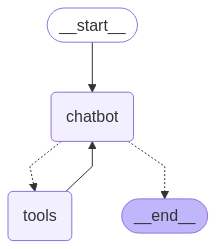

In [52]:
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [53]:
from langchain_core.messages import HumanMessage
import pprint
config = {"configurable": {"thread_id": "20"}}
message = graph.invoke(
        {
            "messages": [
                (
                    "user",
                    """Recomend if buy or sell UBS based in Calculations of the Bollinger Bands and Fibonacci Retracement Strategy score.
                    
                    data period = 1 year  # 1 year of data
                    window = 20    # 20-day Bollinger Bands
                     4 days to calculate the scores
                     """,
                )
            ]
        },
        config,
    )

     


[*********************100%***********************]  1 of 1 completed


In [55]:
message

{'messages': [HumanMessage(content='Recomend if buy or sell UBS based in Calculations of the Bollinger Bands and Fibonacci Retracement Strategy score.\n\n                    data period = 1 year  # 1 year of data\n                    window = 20    # 20-day Bollinger Bands\n                     4 days to calculate the scores\n                     ', additional_kwargs={}, response_metadata={}, id='cc8f23f8-76c1-4fc0-ac41-f8d5e0dc5eee'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_mQtttoEZ8h8v5X9G8b4ejcV7', 'function': {'arguments': '{"ticker":"UBS","period":"1y","window":20,"n":4}', 'name': 'calculate_bollinger_fibonacci_score'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 893, 'total_tokens': 927, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_t

In [56]:
print(message["messages"][-1].content)

Based on the Bollinger Bands and Fibonacci Retracement Strategy scores for UBS over the past 4 days:

- The latest strategy scores are: -4.00, -3.00, -3.00, and -3.00.
- All scores fall within the "Hold" zone (between -20 and +20).

Recommendation: Hold. There is no strong buy or sell signal according to this combined technical analysis strategy. UBS is currently not providing a decisive direction for new buy or sell positions based on these indicators.


In [57]:
from langchain_core.messages import HumanMessage
import pprint
config = {"configurable": {"thread_id": "20"}}
message = graph.invoke(
        {
            "messages": [
                (
                    "user",
                    """Recomend if buy or sell TLSA based in Calculations of the Bollinger Bands and Fibonacci Retracement Strategy score.
                    
                    data period = 6 months
                    window = 30    
                            """,
                )
            ]
        },
        config,
    )


[*********************100%***********************]  1 of 1 completed


In [58]:
message

{'messages': [HumanMessage(content='Recomend if buy or sell TLSA based in Calculations of the Bollinger Bands and Fibonacci Retracement Strategy score.\n\n                    data period = 6 months\n                    window = 30    \n                            ', additional_kwargs={}, response_metadata={}, id='5c1c43a9-499d-414e-9437-e5564098f2c5'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_rr7IHgPKJSLta4QpqteQRkSu', 'function': {'arguments': '{"ticker":"TSLA","period":"6mo","window":30}', 'name': 'calculate_bollinger_fibonacci_score'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 870, 'total_tokens': 900, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_cf18407276', '

In [59]:
print(message["messages"][-1].content)

Based on the Bollinger Bands and Fibonacci Retracement Strategy calculations for TSLA over the last three trading days (using a 6-month period and a 30-day window):

- Latest trading day (2025-05-02): Strategy score = 1.00 (Signal: Hold)
- Previous day (2025-05-01): Strategy score = -1.00 (Signal: Hold)
- Two days prior (2025-04-30): Strategy score = -3.00 (Signal: Hold)

Recommendation: The signals are all within the "Hold" zone (score between -20 and +20), indicating neither a strong buy nor sell opportunity at this moment. It is best to hold your position and wait for a clearer signal out of this neutral range before taking action.
